In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

In [179]:
#just taking the code I used for the regression
diamond_raw = pd.read_csv('diamond_preprocessed.csv')
diamond_df = pd.DataFrame(diamond_raw)
diamond_df.head()

,carat,average us salary,number of diamonds mined (millions),depth,table,price,x,y,z,High_Price,...,color_true,clarity_i1,clarity_if,clarity_si1,clarity_si2,clarity_true,clarity_vs1,clarity_vs2,clarity_vvs1,clarity_vvs2
0,0.016667,0.067477,0.958696,0.446429,0.260870,0.000000,0.048458,0.065359,0.277929,0.0,...,False,False,False,False,True,False,False,False,False,False
1,0.005556,0.528923,0.236957,0.142857,0.782609,0.000000,0.035242,0.034858,0.245232,0.0,...,False,False,False,True,False,False,False,False,False,False
2,0.050000,0.447129,0.628261,0.607143,0.521739,0.000746,0.103524,0.119826,0.332425,0.0,...,False,False,False,False,False,False,False,True,False,False
3,0.061111,0.219906,0.891304,0.767857,0.521739,0.000839,0.134361,0.145969,0.365123,0.0,...,False,False,False,False,True,False,False,False,False,False
4,0.022222,0.773725,0.056522,0.678571,0.434783,0.000932,0.046256,0.061002,0.291553,0.0,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
#The target variable will be if it is a premium cut
print(diamond_df['cut_premium'].value_counts())
target_col = "cut_premium"
y = diamond_df[target_col].astype(int).to_numpy().reshape(-1, 1)
#need to reshape so it'll work well 

cut_premium
False    31483
True     10652
Name: count, dtype: int64


In [181]:
X = diamond_df.drop(columns=[target_col]).to_numpy(dtype=float)
#dropping target variable and reshaping into a matrix to work well 

In [182]:
rng = np.random.default_rng(seed=42)
N = len(y)
perm = rng.permutation(N)
split = int(0.8 * N)
train_idx, test_idx = perm[:split], perm[split:]
#creating the train test split of the data and making it random
X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]
#applying the random split to the features and targets and creating the train test variables

print("Train shapes:", X_train.shape, y_train.shape)
print("Test  shapes:", X_test.shape,  y_test.shape)

Train shapes: (33708, 34) (33708, 1)
Test  shapes: (8427, 34) (8427, 1)


In [ ]:
class linearRegressionOLS:
    def __init__(self, X_train, y_train):
        #making sure everything is in a good shape
        self.X_train = np.asarray(X_train, dtype=float)
        self.y_train = np.asarray(y_train).reshape(-1, 1)
        self.n_train, self.d = self.X_train.shape
        self.scaler = None

        self.W = np.zeros((self.d, 1))
        self.b = 0.0            

    
    
    def safe_inverse_dot(self):
        X_design = np.hstack([np.ones((self.n_train, 1)), self.X_train])  # (n, d+1)
        XtX = X_design.T @ X_design         
        Xty = X_design.T @ self.y_train     
        try:
            w_full = np.linalg.solve(XtX, Xty)   
        except np.linalg.LinAlgError:
            w_full = np.linalg.pinv(XtX) @ Xty
        return w_full
    
    def fit(self):
        w_full = self.safe_inverse_dot()           
        self.b = float(w_full[0, 0])               
        self.W = w_full[1:].reshape(self.d, 1)     
        self.w_full = w_full                       
        return self.W, self.b
    
    def predict(self, X_test):
        X = np.asarray(X_test, dtype=float)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        
        Xs = X
        X_design = np.hstack([np.ones((Xs.shape[0],1)), Xs])
        return X_design @ self.w_full
    
    def mse(self, y_true, y_pred):
        y_true = np.asarray(y_true).reshape(-1,1)
        y_pred = np.asarray(y_pred).reshape(-1,1)
        return float(np.mean((y_true - y_pred)**2))

    def r2(self, y_true, y_pred):
        y_true = np.asarray(y_true).reshape(-1,1)
        y_pred = np.asarray(y_pred).reshape(-1,1)
        ss_res = float(np.sum((y_true - y_pred)**2))
        ss_tot = float(np.sum((y_true - np.mean(y_true))**2))
        return float(1.0 - ss_res / ss_tot) if ss_tot != 0 else 0.0
    

In [184]:
model = linearRegressionOLS(X_train, y_train)
model.fit()
y_pred_test = model.predict(X_test)
print("Test MSE:", model.mse(y_test, y_pred_test))
print("Test R2:",  model.r2(y_test, y_pred_test))



Test MSE: 0.005059299701927368
Test R2: 0.9735467015843677


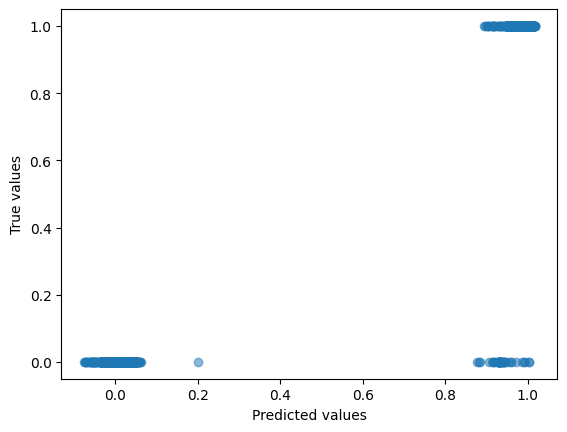

In [185]:
plt.scatter(y_pred_test, y_test, alpha=.5)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.show()

In [186]:
class ridgeRegressionOLS:
    def __init__(self, X_train, y_train):
        self.X_train = np.asarray(X_train, dtype=float)
        self.y_train = np.asarray(y_train).reshape(-1, 1)
        self.n_train, self.d = self.X_train.shape

        # model params 
        #Feature weights
        self.W = np.zeros((self.d, 1))  
        #bias/intercept 
        self.b = 0.0
        #full vector of bias and feature weights
        self.w_full = None     
        #lambda          
        self.lam = None

    #builds a design matrix making it easier to use the feature matrix
    def design(self, X):
        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        return np.hstack([np.ones((X.shape[0], 1)), X])

    #does the XtX math
    def safe_solve(self, A, b):
        try:
            return np.linalg.solve(A, b)
        #just in case XtX is singular, it won't fail and will use pinv
        except np.linalg.LinAlgError:
            return np.linalg.pinv(A) @ b
        
    #Does the ridge regression OLS equation
    def compute_w_full(self, lam, X_design, y):
        XtX = X_design.T @ X_design
        Xty = X_design.T @ y
        I = np.eye(XtX.shape[0])
        I[0,0] = 0.0
        A = XtX + lam * I
        w_full = self.safe_solve(A, Xty)
        return w_full
    
    #Fits the data for the model
    def fit(self, lam):
        lam = float(lam)
        Xd = self.design(self.X_train)
        w_full = self.compute_w_full(lam, Xd, self.y_train)  # (d+1,1)

        # store
        self.w_full = w_full
        self.lam = lam
        self.b = float(w_full[0,0])
        self.W = w_full[1:].reshape(self.d, 1)
        self.y_train_pred = Xd @ w_full
        return self.w_full
    
    def predict(self, X):
        X_design = self.design(X)
        return X_design @ self.w_full

    #calculates MSE
    def mse(self, y_true, y_pred):
        y_true = np.asarray(y_true).reshape(-1,1)
        y_pred = np.asarray(y_pred).reshape(-1,1)
        return float(np.mean((y_true - y_pred)**2))

    #calculates R2
    def r2(self, y_true, y_pred):
        y_true = np.asarray(y_true).reshape(-1,1)
        y_pred = np.asarray(y_pred).reshape(-1,1)
        ss_res = float(np.sum((y_true - y_pred)**2))
        ss_tot = float(np.sum((y_true - np.mean(y_true))**2))
        return float(1.0 - ss_res / ss_tot) if ss_tot != 0 else 0.0


MSE: 0.005060084996318354
R2: 0.9735425955562428


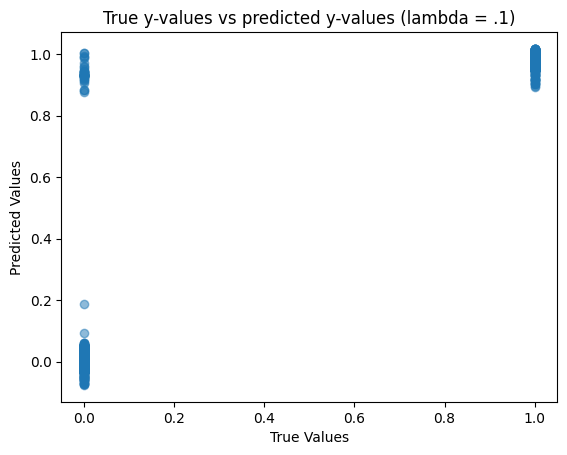

In [187]:
MSEList = []
lambdaList = [0.1, 1, 10, 100, 1000, 10000]
#Trying lambda = .1
model = ridgeRegressionOLS(X_train, y_train)
model.fit(.1)
y_pred_test = model.predict(X_test)
MSEList.append(model.mse(y_test, y_pred_test))
print('MSE:', model.mse(y_test, y_pred_test))
print('R2:', model.r2(y_test, y_pred_test))
plt.scatter(y_test, y_pred_test, alpha=.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True y-values vs predicted y-values (lambda = .1)')
plt.show()

In [188]:
#lambda .1 has the best results
params = {
        'W' : model.W,
        'b' : model.b,
        'w_full' : model.w_full,
        'lam' : model.lam 
}

with open("a1_part_3_weights_JadenPeacock.pkl", "wb") as f:
    pickle.dump(params, f)

MSE: 0.005111231582538101
R2: 0.973275168048895


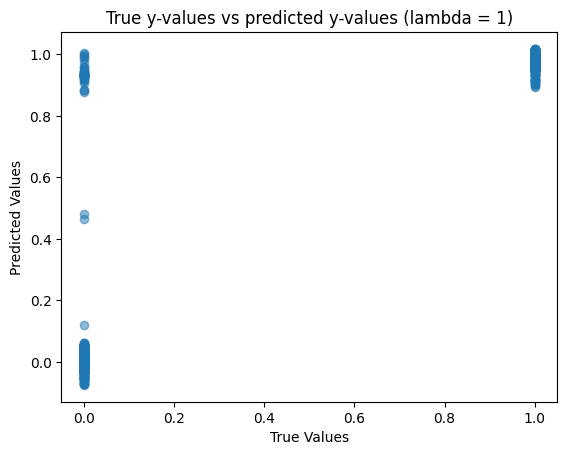

In [189]:
#Trying lambda = 1
model = ridgeRegressionOLS(X_train, y_train)
model.fit(1)
y_pred_test = model.predict(X_test)
MSEList.append(model.mse(y_test, y_pred_test))
print('MSE:', model.mse(y_test, y_pred_test))
print('R2:', model.r2(y_test, y_pred_test))
plt.scatter(y_test, y_pred_test, alpha=.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True y-values vs predicted y-values (lambda = 1)')
plt.show()

MSE: 0.005250158450047436
R2: 0.9725487683294292


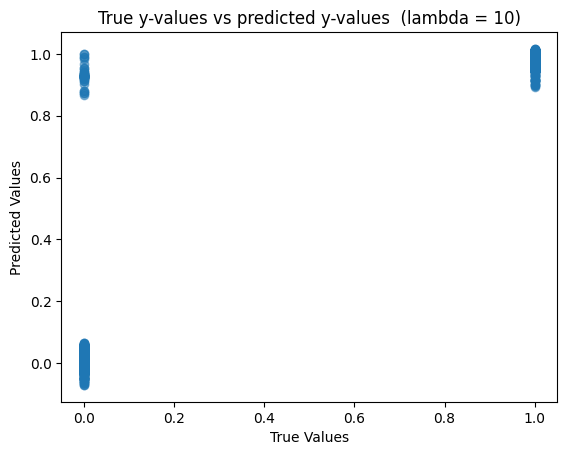

In [190]:
#Trying lambda = 10
model = ridgeRegressionOLS(X_train, y_train)
model.fit(10)
y_pred_test = model.predict(X_test)
MSEList.append(model.mse(y_test, y_pred_test))
print('MSE:', model.mse(y_test, y_pred_test))
print('R2:', model.r2(y_test, y_pred_test))
plt.scatter(y_test, y_pred_test, alpha=.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True y-values vs predicted y-values  (lambda = 10)')
plt.show()

MSE: 0.005776709672694533
R2: 0.9697956172127848


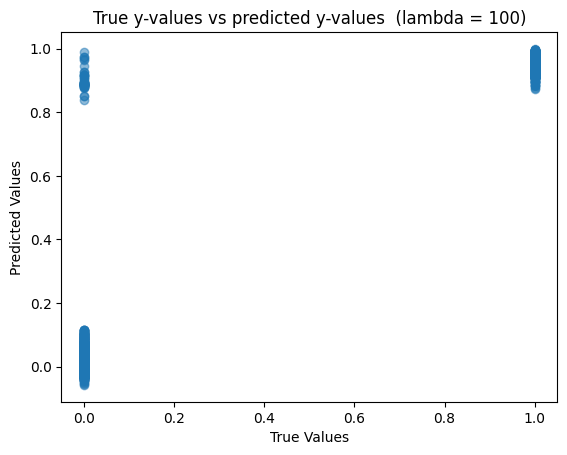

In [191]:
#Trying lambda = 100
model = ridgeRegressionOLS(X_train, y_train)
model.fit(100)
y_pred_test = model.predict(X_test)
MSEList.append(model.mse(y_test, y_pred_test))
print('MSE:', model.mse(y_test, y_pred_test))
print('R2:', model.r2(y_test, y_pred_test))
plt.scatter(y_test, y_pred_test, alpha=.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True y-values vs predicted y-values  (lambda = 100)')
plt.show()

MSE: 0.023638484787316068
R2: 0.8764026784311596


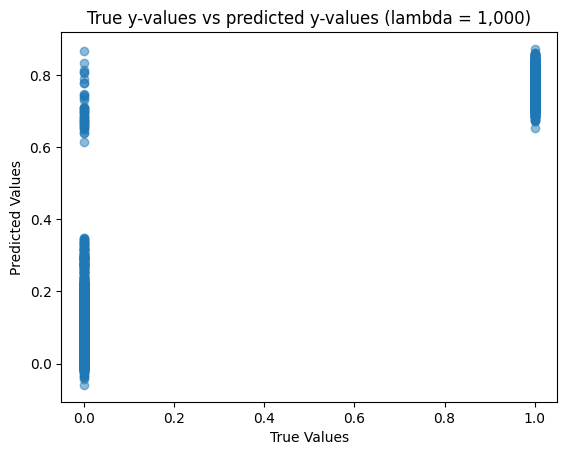

In [192]:
#trying lambda = 1,000
model = ridgeRegressionOLS(X_train, y_train)
model.fit(1000)
y_pred_test = model.predict(X_test)
MSEList.append(model.mse(y_test, y_pred_test))
print('MSE:', model.mse(y_test, y_pred_test))
print('R2:', model.r2(y_test, y_pred_test))
plt.scatter(y_test, y_pred_test, alpha=.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True y-values vs predicted y-values (lambda = 1,000)')
plt.show()

MSE: 0.11945462213639417
R2: 0.3754138017763966


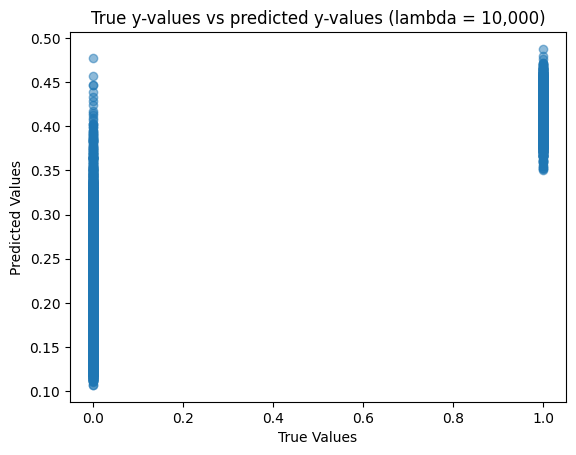

In [193]:
#trying lambda = 10000
model = ridgeRegressionOLS(X_train, y_train)
model.fit(10000)
y_pred_test = model.predict(X_test)
MSEList.append(model.mse(y_test, y_pred_test))
print('MSE:', model.mse(y_test, y_pred_test))
print('R2:', model.r2(y_test, y_pred_test))
plt.scatter(y_test, y_pred_test, alpha=.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True y-values vs predicted y-values (lambda = 10,000)')
plt.show()

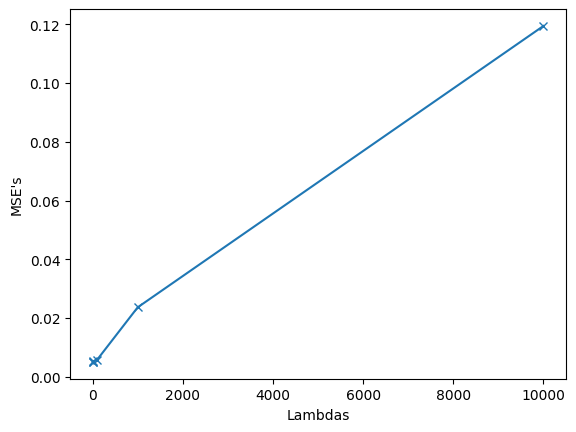

In [194]:
plt.plot(lambdaList, MSEList, marker='x')
plt.xlabel("Lambdas")
plt.ylabel("MSE's")
plt.show()

**Discussion**
* The Benefits is that it can be fast and good for small problems, and relatively simple to implement. Th drawbacks is when features increase it may scale badly and perform works
* The strengths of linear regression is that it is easy to implement, the biggest drawback is that if your data isn't linear or has outliers it can negatively affect performance greatly
* Ridge regression can help with if you have a high variance. Ridge regression will increase bias but lower variance
* for my dataset if I had a large lambda my mse would increase and R2 would decrease, the plain OLS and ridge would have the same stats when the lambda was very low, at like .1